On 1-Dec-2020, the S&P500 (SPX) index value was 3662.45, while the SPDR
S&P500 Exchange Traded Fund (SPY) stock price was 366.02. The call and
put option prices (bid & offer) over 3 maturities are provided in the
spreadsheet:
• SPX options.csv
• SPY options.csv
The discount rate on this day is in the file: zero rates 20201201.csv.
Calibrate the following models to match the option prices:
1 Displaced-diffusion model
2 SABR model (fix β = 0.7)
Plot the fitted implied volatility smile against the market data.
Report the model parameters:
1 σ, β
2 α, ρ, ν
And discuss how does change β in the displaced-diffusion model and ρ, ν in the
SABR model affect the shape of the implied volatility

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq, least_squares
import matplotlib.pylab as plt
import math

First, we shall implement the SABR model. The implied Black volatility of the SABR model is given by

\begin{equation}
\sigma_{\text{SABR}}(F_0, K, \alpha, \beta, \rho, \nu) = \frac{\alpha}{(F_0K)^{(1-\beta)/2} \left\{ 1 + \frac{(1-\beta)^2}{24}\log^2\left(\frac{F_0}{K}\right) + \frac{(1-\beta)^4}{1920}\log^4\left(\frac{F_0}{K}\right) + \cdots \right\} } 
\cdot \frac{z}{x(z)} \cdot \left\{ 1 + \left[ \frac{(1-\beta)^2}{24} \frac{\alpha^2}{(F_0K)^{1-\beta}} + \frac{1}{4} \frac{\rho \beta \nu \alpha}{(F_0K)^{(1-\beta)/2}} + \frac{2-3\rho^2}{24}\nu^2 \right] T + \cdots \right\},
\notag
\end{equation}

where

\begin{equation}
z = \frac{\nu}{\alpha} (F_0K)^{(1-\beta)/2} \log\left(\frac{F_0}{K}\right), \notag
\end{equation}

and

\begin{equation}
x(z) = \log \left[ \frac{\sqrt{1-2\rho z+z^2} + z - \rho}{1 - \rho} \right]. \notag
\end{equation}


In [58]:
def ddcalibration(x, option_prices, strikes, r, F, T) -> float:
    """
    Function to obtain total squared error between estimated (using parameters in x) and actual price

    Parameters:
        x: list of DD parameters with sigma, beta
        strikes: K,
        vols: list of market implied volatility,
        F: stock future price adjusted for T or [S*np.exp(r*T)]
        T: years to expiry

    Return:
        total error computed from list of vol provided
    """
    err = 0.0
    
    for i, price in enumerate(option_prices):
        F_dd = F / x[1]
        K_dd = strikes[i] + (1 - x[1]) / x[1] * F 

        if strikes[i] > F:
            est_price = BlackCall(F_dd, K_dd, r, x[0] * x[1], T)
        else:
            est_price = BlackPut(F_dd, K_dd, r, x[0] * x[1], T)
        
        err += (price - est_price)**2
    
    return err

def BlackCall(F, K, r, sig, T)->tuple:
    """
    Calculate the Black model prices of European call and put options.

    Parameters:
    ----------
    F0 : float
        Current futures price.
    K : float
        Strike price of the option.
    T : float
        Time to expiration in years.
    r : float
        Risk-free interest rate (as a decimal).
    sig : float
        Volatility of the underlying asset (annualized).

    Returns:
    -------
    tuple
        A tuple containing the call option price and the put option price (call_price, put_price).
    """
    d = (math.log(F/K) +.5*(sig**2)*T) / \
          (sig*T**.5)
    
    return math.exp(-r*T) * ( F*norm.cdf( d) - K *norm.cdf( d) )

def BlackPut(F, K, r, sig, T)->tuple:
    """
    Calculate the Black model prices of European call and put options.

    Parameters:
    ----------
    F0 : float
        Current futures price.
    K : float
        Strike price of the option.
    T : float
        Time to expiration in years.
    r : float
        Risk-free interest rate (as a decimal).
    sig : float
        Volatility of the underlying asset (annualized).

    Returns:
    -------
    tuple
        A tuple containing the call option price and the put option price (call_price, put_price).
    """
    d = (math.log(F/K) +.5*(sig**2)*T) / \
          (sig*T**.5)
    
    return math.exp(-r*T) * ( K *norm.cdf(-d) - F*norm.cdf(-d) )
    
    return err

In [2]:
## SABR functions and constants
beta = 0.7 # config for SABR modelbeta = 0.7 # config for SABR model
S_spx = 3662.45
S_spy = 366.02

def calculate_sabr_params(df, df_rates, S, impliedVolatility, sabrcalibration, SABR, beta=0.7):
    """
    Function to execute SABR parameter search based on option prices, rates, and beta.
    Prints out estimated SABR parameters for unique expiry dates in df

    Parameters:
        df: ticker data,
        df_rates: zero curve for annual vol with tenors in days column
        S: spot px
        impliedVolatility: function returning market implied vol
        SABR: function to return sigma for given parameters
        beta: fixed beta for SABR

    Return: None
    """
    # Define expiration dates and calculate days to expiry
    exdates = sorted(df['exdate'].unique())[:3]
    days_to_expiry = [(pd.Timestamp(str(date)) - pd.Timestamp('2020-12-01')).days for date in exdates]
    
    # Interpolate risk-free rates for days to expiry
    arr_rates = np.interp(days_to_expiry, df_rates['days'].values, df_rates['rate'].values)
    dict_ex_date_rate = dict(zip(exdates, arr_rates))
    
    # Initialize list to store SABR parameters for each expiration date
    sabr_params = []

    # Loop through each expiration date
    for exdate, r in dict_ex_date_rate.items():
        df_ex = df[df["exdate"] == exdate].copy()
        T = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days / 365
        r = r / 100
        F = S * np.exp(r * T)

        # Calculate implied volatilities
        df_ex['vols'] = df_ex.apply(lambda x: impliedVolatility(S, x['strike'], r, x['mid'], T, x['payoff']), axis=1)
        df_ex.dropna(inplace=True)

        # Filter and collect strikes and implied vols
        call_df, put_df = df_ex[df_ex['payoff'] == 'call'], df_ex[df_ex['payoff'] == 'put']
        strikes = put_df['strike'].values
        impliedvols = [
            call_df[call_df['strike'] == K]['vols'].values[0] 
                if K > S else put_df[put_df['strike'] == K]['vols'].values[0]
                    for K in strikes
        ]
        df_iv = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})
        
        # Calibrate SABR parameters
        initialGuess = [.02, .2, .1]
        res = least_squares(lambda x: sabrcalibration(x, df_iv['strike'], df_iv['impliedvol'], F, T), initialGuess)
        alpha, rho, nu = res.x
        sabr_params.append({'exdate': exdate, 'alpha': alpha, 'rho': rho, 'nu': nu})
        
        # Plot SABR vs Market implied volatilities
        sabrvols = [SABR(F, K, T, alpha, beta, rho, nu) for K in strikes]
        plt.figure(tight_layout=True)
        plt.title(f"{exdate} Market vs SABR Implied Vol")
        plt.plot(strikes, df_iv['impliedvol'], 'gs', label='Market Implied Vols')
        plt.plot(strikes, sabrvols, 'm--', label='SABR Implied Vols')
        plt.legend()
        plt.show()
    
    # Output calibrated SABR parameters
    for params in sabr_params:
        print(f"Exdate {params['exdate']}: alpha = {params['alpha']:.3f}, rho = {params['rho']:.3f}, nu = {params['nu']:.3f}")

def sabrcalibration(x, strikes, vols, F, T) -> float:
    """
    Function to obtain total squared error between estimated (using parameters in x) and actual given(vols) sigmas
    float

    Parameters:
        x: list of SABR parameters with alpha, rho, nu,
        strikes: K,
        vols: list of market implied volatility,
        F: stock future price adjusted for T or [S*np.exp(r*T)]
        T: years to expiry

    Return:
        total error computed from list of vol provided
    """
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2
    
    return err

def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol

def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

def BlackScholesLognormalCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def BlackScholesLognormalPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

In [3]:
# get market prices and prepare data
df_rates = pd.read_csv("zero_rates_20201201.csv")\
            .sort_values('days')


def preprocess_options_data(file_path):
    """
    Preprocess options data by calculating mid-price, scaling strike prices, 
    and mapping call/put flags.

    Parameters:
    - file_path (str): Path to the CSV file containing options data.

    Returns:
    - DataFrame: Processed options data with 'mid', 'strike', and 'payoff' columns.
    """
    df = pd.read_csv(file_path)
    df['mid'] = 0.5 * (df['best_bid'] + df['best_offer'])
    df['strike'] = df['strike_price'] * 0.001  # Adjusting strike price scale
    df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
    return df

# Example usage
df_spx = preprocess_options_data("SPX_options.csv")
df_spy = preprocess_options_data("SPY_options.csv")


# Displaced-Diffusion Model
## SPX

In [4]:
exdates = sorted(df_spx['exdate'].unique())[:3].copy()
days_to_expiry = [(pd.Timestamp(str(date)) - pd.Timestamp('2020-12-01')).days \
                    for date in exdates]
arr_rates = np.interp(
                        days_to_expiry,df_rates['days'].values, 
                        df_rates['rate'].values,
                    )
dict_ex_date_rate = dict(zip(exdates, arr_rates))



In [29]:
exdate = df_spx["exdate"].unique()[0]
r = arr_rates[0]

# Filter for the current expiration date
df_ex = df_spx[df_spx["exdate"] == exdate].copy()
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
r = r/100
T = days_to_expiry / 365
F = S_spx * np.exp(r * T)

# Calculate implied volatilities
df_ex['vols'] = df_ex.apply(lambda x: impliedVolatility(S_spx, 
                                                        x['strike'], 
                                                        r, 
                                                        x['mid'], 
                                                        T, 
                                                        x['payoff']),
                                                        axis=1)
df_ex.dropna(inplace=True)  # Remove rows where vol calculation failed

# collect all strikes and IV from OTM call and put
call_df = df_ex[df_ex['payoff'] == 'call']
put_df = df_ex[df_ex['payoff'] == 'put']
strikes = put_df['strike'].values
impliedvols, option_prices = [], []
for K in strikes:    
    if K > S_spx:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
        option_prices.append(call_df[call_df['strike'] == K]['mid'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
        option_prices.append(put_df[put_df['strike'] == K]['mid'].values[0])
df_iv = pd.DataFrame({'strike': strikes, 
                      'impliedvol': impliedvols,
                      'option_price': option_prices})


In [73]:
dd_params = []
initialGuess = [.02, 0.08]        # sigma, beta

res = least_squares(lambda x:ddcalibration(x, option_prices, strikes, r, F, T),
                    initialGuess)

dd_sigma, dd_beta = res.x
dd_params.append({'exdate': exdate, 'dd_sigma': dd_sigma, 'dd_beta': dd_beta})

In [74]:
res.x


array([0.00035082, 0.08000006])

In [75]:
df_iv

,strike,impliedvol,option_price,dd_iv
0,100.0,4.685324,0.025,4.585169
1,200.0,3.741195,0.025,3.584597
2,300.0,3.204791,0.025,3.007697
3,400.0,2.830325,0.025,2.602901
4,500.0,2.542973,0.025,2.292584
...,...,...,...,...
406,5000.0,0.436196,0.050,0.208490
407,5100.0,0.461523,0.050,0.218316
408,5200.0,0.486234,0.050,0.227653
409,5300.0,0.486495,0.025,0.225470


In [76]:
df_iv['dd_iv'] = df_iv['impliedvol']*S_spx/\
                (S_spx + dd_beta * df_iv['strike'])

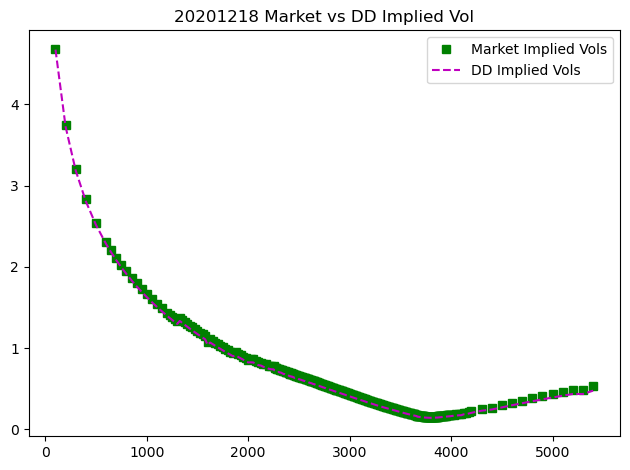

In [77]:
plt.figure(tight_layout=True)
plt.title(f"{exdate} Market vs DD Implied Vol")
plt.plot(strikes, df_iv['impliedvol'], 'gs', label='Market Implied Vols')
plt.plot(strikes, df_iv['dd_iv'], 'm--', label='DD Implied Vols')
plt.legend()
plt.show()

# SABR model

## SPX

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_2025/1808226220.py:82: RuntimeWarning: invalid value encountered in double_scalars
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_2025/1808226220.py:82: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


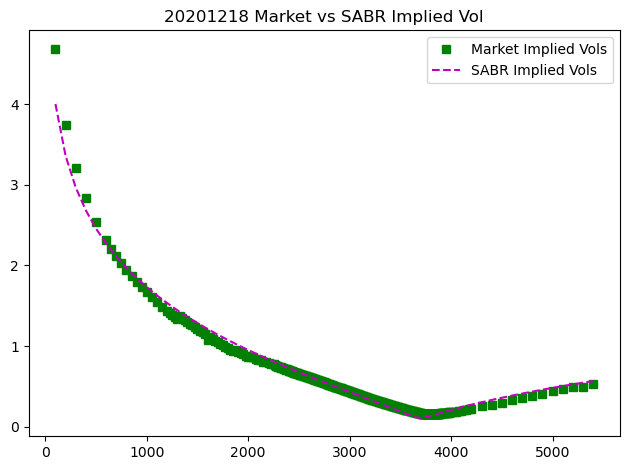

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_2025/1808226220.py:82: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_2025/1808226220.py:82: RuntimeWarning: invalid value encountered in double_scalars
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


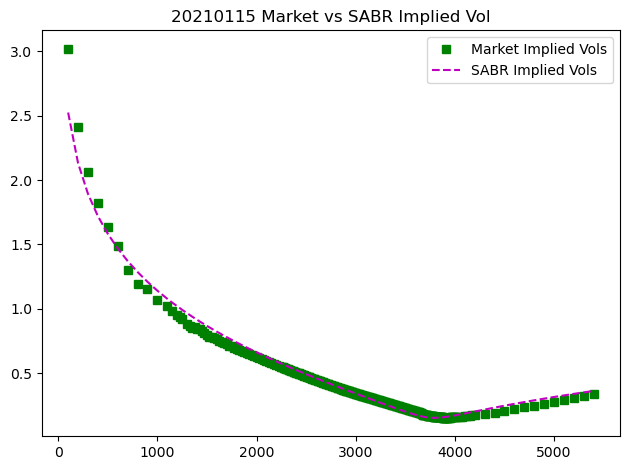

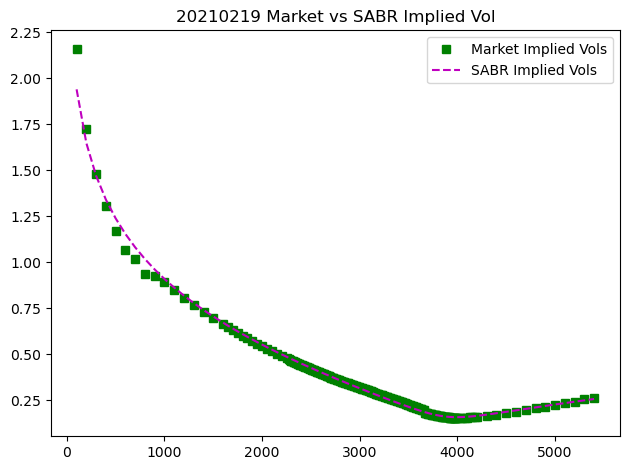

Exdate 20201218: alpha = 1.212, rho = -0.301, nu = 5.460
Exdate 20210115: alpha = 1.817, rho = -0.404, nu = 2.790
Exdate 20210219: alpha = 2.140, rho = -0.575, nu = 1.842


In [4]:
calculate_sabr_params(df_spx, df_rates, S_spx, impliedVolatility, sabrcalibration, SABR, beta=0.7)

## SPY

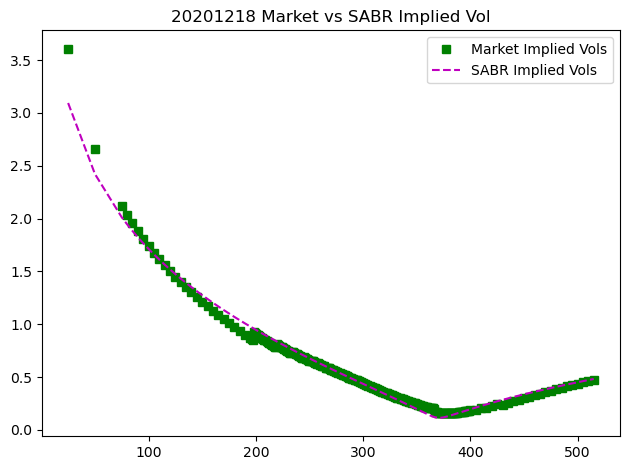

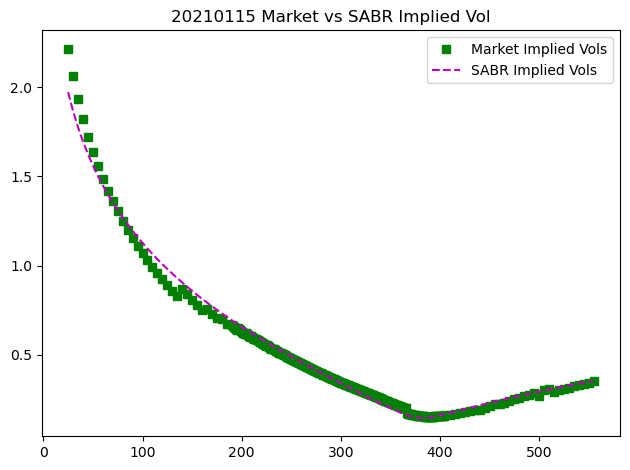

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_2025/1808226220.py:82: RuntimeWarning: invalid value encountered in double_scalars
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


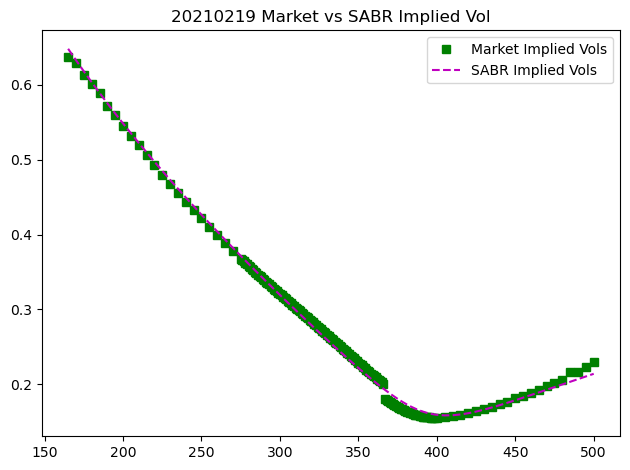

Exdate 20201218: alpha = 0.665, rho = -0.412, nu = 5.250
Exdate 20210115: alpha = 0.908, rho = -0.489, nu = 2.729
Exdate 20210219: alpha = 1.121, rho = -0.633, nu = 1.742


In [5]:
calculate_sabr_params(df_spy, df_rates, S_spy, impliedVolatility, sabrcalibration, SABR, beta=0.7)